In [53]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim
import torch.nn.init
from torch.autograd import Variable
from torch import FloatTensor
import sklearn.datasets
import matplotlib.pylab as plt
import random
import math
from IPython import display
import seaborn as sbn
import pandas as pd
%matplotlib inline

(209, 1, 28, 28)


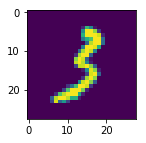

In [148]:
mnist = sklearn.datasets.fetch_mldata('MNIST original', data_home='.')
X = mnist['data'].astype('float').reshape(-1, 1, 28, 28)
Y = mnist['target']
XY = list( zip(X,Y) )
np.random.shuffle(XY)
X = [x for x,y in XY if y in [3, 6, 8] ]
Y = [y for x,y in XY if y in [3, 6, 8] ]
X = np.array_split(X, 100)
Y = np.array_split(Y, 100)

print(X[0].shape)

X = [ x / 255. for x in X ]

plt.figure(figsize=(2,2))
plt.imshow(X[0][0,0])
plt.show()

In [149]:
X[0].shape, Y[0].shape

((209, 1, 28, 28), (209,))

# Классический Autoencoder

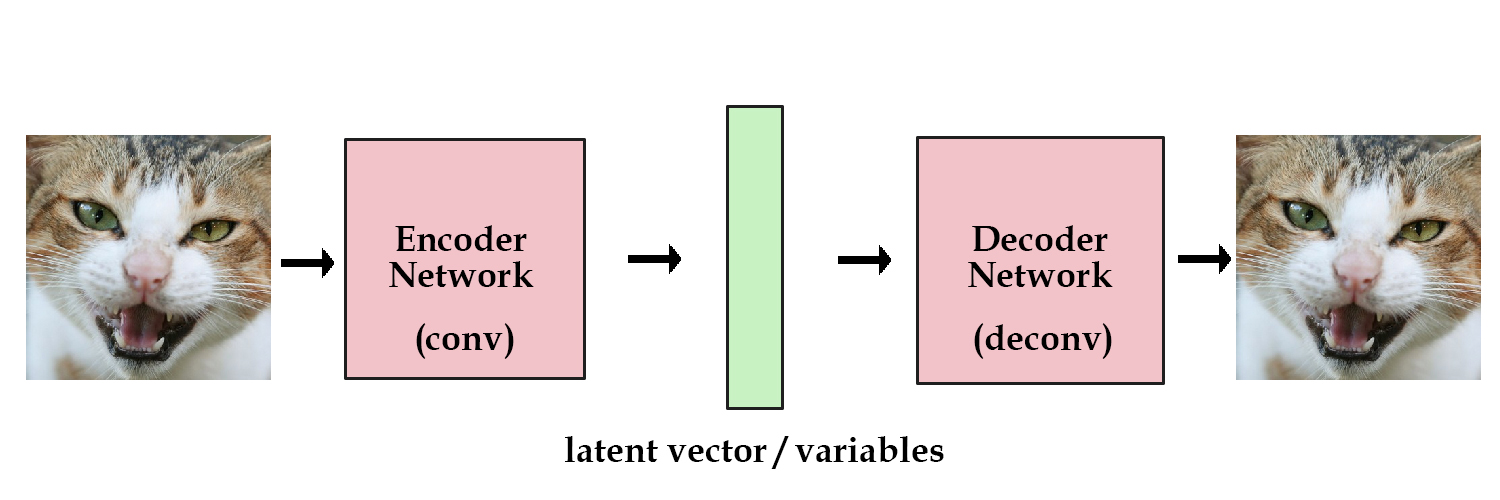

In [69]:
class conv_ae(nn.Module):
    
    def __init__(self):
        super(conv_ae, self).__init__()
        
        self.encoder = nn.Sequential( # 1x28x28 ->
            nn.Conv2d(1, 8, 3), # 8x26x26
            nn.ReLU(),
            
            nn.Conv2d(8, 16, 3), # 16x24x24
            nn.ReLU(),
            nn.MaxPool2d(2), # 16x12x12
            
            nn.Conv2d(16, 32, 3), # 32x10x10
            nn.ReLU(),
            nn.MaxPool2d(2), #32x5x5
            
            nn.Conv2d(32, 64, 3), # 32x3x3 = 288
            nn.ReLU(),
            nn.MaxPool2d(3), # 32x1x1
            
            nn.Conv2d(64, 2, 1),
        )
        
        
        self.decoder = nn.Sequential(
            nn.Conv2d(2, 64, 1),
            
            nn.Upsample(scale_factor=3),

            nn.ConvTranspose2d(64, 32, 3),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            
            nn.ConvTranspose2d(32, 16, 3),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            
            nn.ConvTranspose2d(16, 8, 3),
            nn.ReLU(),
            
            nn.ConvTranspose2d(8, 1, 3),
            nn.ReLU()
            
        )
        
        self.initialize()
        
    def initialize(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
        
    def forward(self, x):
        x = self.encoder(x)
        self.embeding = x
        x = self.decoder(x)
        return x

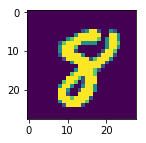

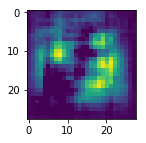

In [74]:
# Инициализируем сеть и убеждаемся, что изначально она выдает мусор.
net = conv_ae().cuda()
x = Variable(FloatTensor(X[0][0].reshape((1, 1, 28, 28)))).cuda()
y = net(x)

plt.figure(figsize=(2,2))
plt.imshow(X[0][0].reshape((28,28)))

plt.figure(figsize=(2,2))
plt.imshow(y.cpu().data.numpy()[0,0])

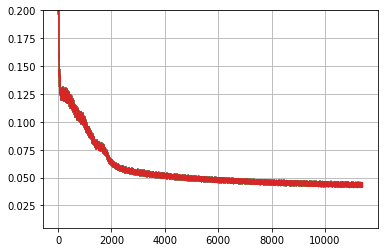

KeyboardInterrupt: 

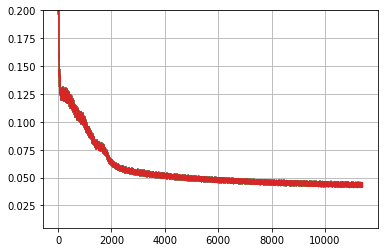

In [75]:
criterion = nn.MSELoss().cuda()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

loss_aсс = []

for ep in range(150):

    random.shuffle(X)

    for batch in X:
        x = Variable(FloatTensor(batch)).cuda()

        optimizer.zero_grad()
        y = net(x)
        loss = criterion(y, x)
        loss.backward()
        optimizer.step()

        loss_aсс.append(loss.data[0])
        
    plt.ylim(0.005, 0.2)
    plt.grid(True)
    plt.plot(loss_aсс)
    display.clear_output(wait=True)
    display.display(plt.gcf())

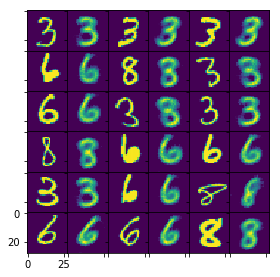

In [76]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid

fig = plt.figure(figsize=(20,20))

grid = AxesGrid(fig, 141,  # similar to subplot(141)
                nrows_ncols=(6, 6),
                axes_pad=0.00,
                label_mode="1",)
x = Variable(FloatTensor(X[0])).cuda()
y = net(x)
for i in range(0, 36, 2):
    im = grid[i].imshow(x[i].cpu().data.numpy().reshape((28,28)), interpolation="nearest")
    im = grid[i+1].imshow(y.cpu().data.numpy()[i,0], interpolation="nearest")

# Denoising

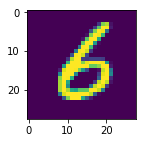

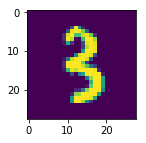

In [117]:
a = X[0][3].reshape(28,28)
b = X[0][7].reshape(28,28)

plt.figure(figsize=(2,2))
plt.imshow(a)
plt.figure(figsize=(2,2))
plt.imshow(b)

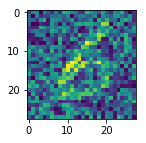

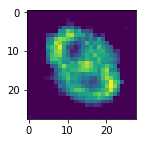

In [112]:
plt.figure(figsize=(2,2))
a_n = a + np.random.uniform(-1, 1, size=(28,28))
plt.imshow(a_n)

a_d = net(Variable(FloatTensor(a_n.reshape(1,1,28,28))).cuda())

plt.figure(figsize=(2,2))
plt.imshow(a_d.cpu().data.numpy().reshape((28,28)))

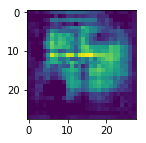

In [91]:
dae_net = conv_ae().cuda()

a_d = dae_net(Variable(FloatTensor(a_n.reshape(1,1,28,28))).cuda())

plt.figure(figsize=(2,2))
plt.imshow(a_d.cpu().data.numpy().reshape((28,28)))

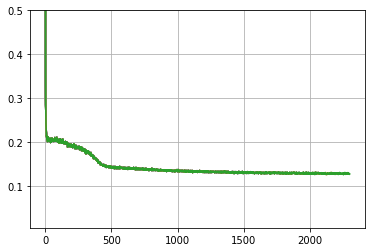

KeyboardInterrupt: 

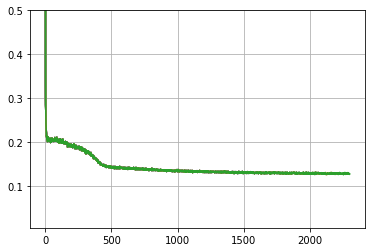

In [92]:
criterion = nn.MSELoss().cuda()
optimizer = torch.optim.Adam(dae_net.parameters(), lr=0.001)

loss_aсс = []

for ep in range(100):

    random.shuffle(X)

    for batch in X:
        batch_noiced = batch + np.random.uniform(-0.5, 0.5, size=batch.shape)
        x = Variable(FloatTensor(batch_noiced)).cuda()
        y = Variable(FloatTensor(batch)).cuda()
        
        optimizer.zero_grad()
        y = dae_net(x)
        loss = criterion(y, x)
        loss.backward()
        optimizer.step()

        loss_aсс.append(loss.data[0])
    
    plt.ylim(0.005, 0.5)
    plt.grid(True)
    plt.plot(loss_aсс)
    display.clear_output(wait=True)
    display.display(plt.gcf())

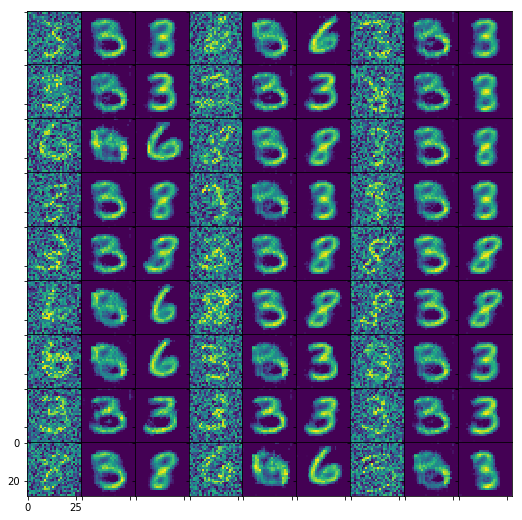

In [93]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid

fig = plt.figure(figsize=(40,40))

grid = AxesGrid(fig, 141,  # similar to subplot(141)
                nrows_ncols=(9, 9),
                axes_pad=0.00,
                label_mode="1",)

batch = X[0]
batch_noiced = batch + np.random.uniform(-1., 1., size=batch.shape)
batch_noiced_v = Variable(FloatTensor(batch_noiced)).cuda()
y_dn = dae_net(batch_noiced_v)
y = net(batch_noiced_v)

for i in range(0, 81, 3):
    grid[i].imshow(batch_noiced[i,0], interpolation="nearest")
    grid[i+1].imshow(y.cpu().data.numpy()[i,0], interpolation="nearest")
    grid[i+2].imshow(y_dn.cpu().data.numpy()[i,0], interpolation="nearest")
    

# Latent space

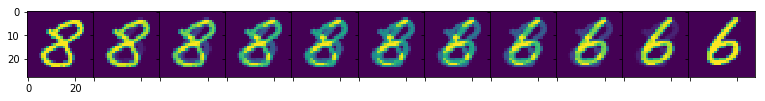

In [113]:
fig = plt.figure(figsize=(60,5))

grid = AxesGrid(fig, 141,  # similar to subplot(141)
                nrows_ncols=(1, 11),
                axes_pad=0.00,
                label_mode="1",)

for k in range(11):
    z = k/10. * a + (1. - k/10.) * b
    im = grid[k].imshow(z, interpolation="nearest")

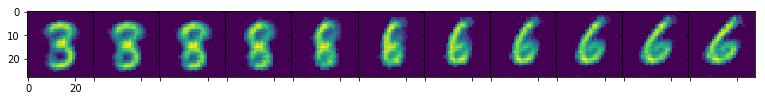

In [118]:
x = Variable(FloatTensor(a.reshape((1, 1, 28, 28)))).cuda()
a_emb = net.encoder(x)   
x = Variable(FloatTensor(b.reshape((1, 1, 28, 28)))).cuda()
b_emb = net.encoder(x) 

fig = plt.figure(figsize=(60,5))

grid = AxesGrid(fig, 141,  # similar to subplot(141)
                nrows_ncols=(1, 11),
                axes_pad=0.00,
                label_mode="1",)

for k in range(11):
    z_emb = k/10. * a_emb + (1. - k/10.) * b_emb
    z = net.decoder(z_emb)
    im = grid[k].imshow(z.cpu().data.numpy().reshape(28,28), interpolation="nearest")

[ 0.43769252  1.23355639]


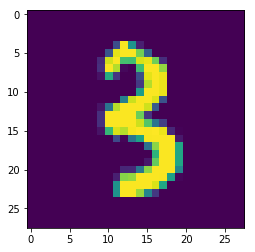

In [119]:
plt.imshow(b)
a_emb = net.encoder(Variable(FloatTensor(b.reshape(1,1,28,28))).cuda())
print(a_emb.cpu().data.numpy().reshape(2))

In [120]:
batch = X[0]
y = net.encoder(Variable(FloatTensor(batch)).cuda()).cpu().data.numpy().reshape(-1, 2)

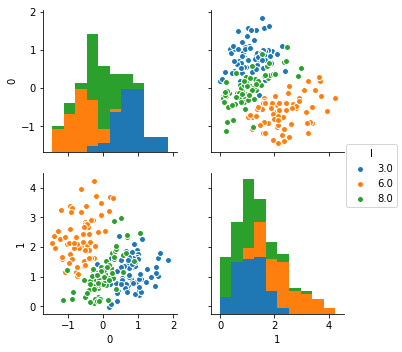

In [121]:
df = pd.DataFrame(y)
df['l'] = Y[0]

sbn.pairplot(df, hue='l', vars=[0, 1])

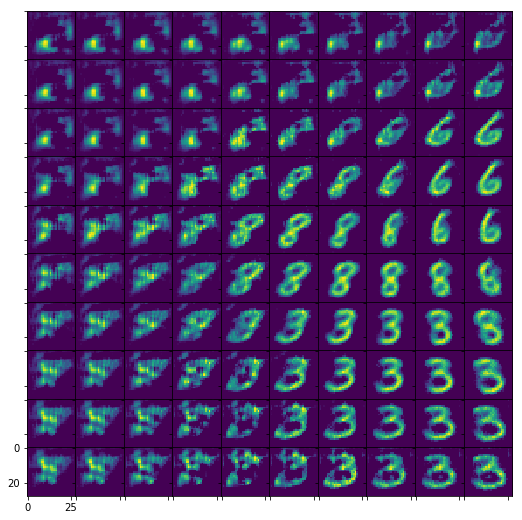

In [157]:
fig = plt.figure(figsize=(40,40))

grid = AxesGrid(fig, 141,  # similar to subplot(141)
                nrows_ncols=(10, 10),
                axes_pad=0.00,
                label_mode="1",)

for i in range(10):
    for j in range(10):
        a_emb[0,1,0,0] = (i-5)/2.;
        a_emb[0,0,0,0] = (j-5)/2.;

        y = net.decoder(a_emb)
        im = grid[i+10*j].imshow(y.cpu().data.numpy()[0,0], interpolation="nearest")


# Variational Autoencoder (VAE)

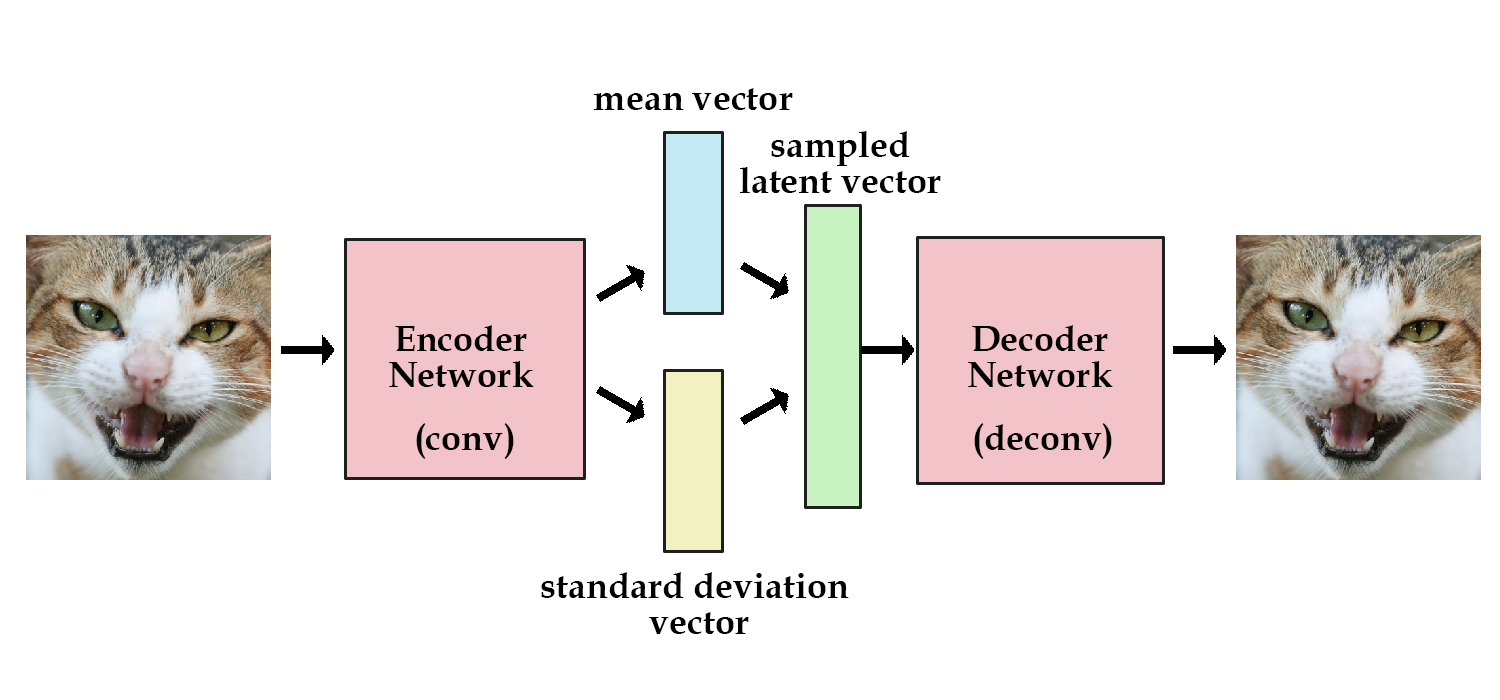

In [124]:
class conv_vae(nn.Module):
    
    def __init__(self):
        super(conv_vae, self).__init__()
        
        self.encoder = nn.Sequential( # 1x28x28 ->
            nn.Conv2d(1, 8, 3), # 8x26x26
            nn.ReLU(),
            
            nn.Conv2d(8, 16, 3), # 16x24x24
            nn.ReLU(),
            nn.MaxPool2d(2), # 16x12x12
            
            nn.Conv2d(16, 32, 3), # 32x10x10
            nn.ReLU(),
            nn.MaxPool2d(2), #32x5x5
            
            nn.Conv2d(32, 64, 3), # 32x3x3 = 288
            nn.ReLU(),
            nn.MaxPool2d(3), # 64x1x1
            
        )
        
        self.mu = nn.Linear(64, 2)
        self.logvar = nn.Linear(64, 2)
        
        
        self.decoder = nn.Sequential(
            nn.Conv2d(2, 64, 1, 1),
            nn.Upsample(scale_factor=3),

            nn.ConvTranspose2d(64, 32, 3),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            
            nn.ConvTranspose2d(32, 16, 3),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            
            nn.ConvTranspose2d(16, 8, 3),
            nn.ReLU(),
            
            nn.ConvTranspose2d(8, 1, 3),
            nn.ReLU()
            
        )
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            
    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

    
    def encode(self, x):
        x = self.encoder(x)
        x = x.view(-1, 64)
        return self.mu(x), self.logvar(x)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        self.z = z.view(-1, 2, 1, 1)
        x = self.decoder(self.z)
        return x, mu, logvar

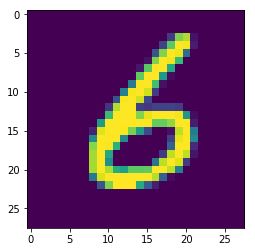

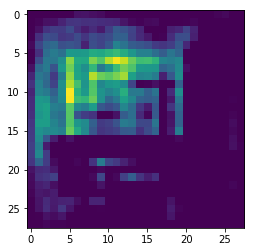

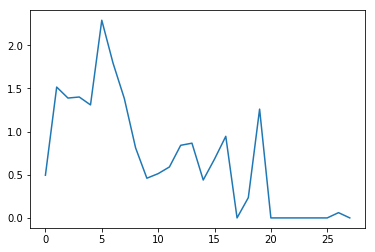

In [136]:
vae_net = conv_vae().cuda()
r, m, l = vae_net(Variable(FloatTensor(a.reshape(1,1,28,28))).cuda())
i = r.cpu().data.numpy()
plt.imshow(a)
plt.show()
plt.imshow(i[0,0])
plt.show()
plt.plot(i[0,0,15])

In [137]:
mse_loss = nn.MSELoss().cuda()
def loss_function(recon_x, x, mu, logvar, batch_size):
    BCE = mse_loss(recon_x, x)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # Normalise by same number of elements as in reconstruction
    KLD /= batch_size * 784.

    return BCE + KLD


In [138]:
optimizer = torch.optim.Adam(vae_net.parameters(), lr=0.001)

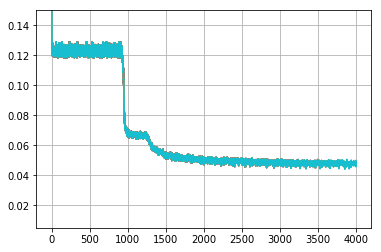

KeyboardInterrupt: 

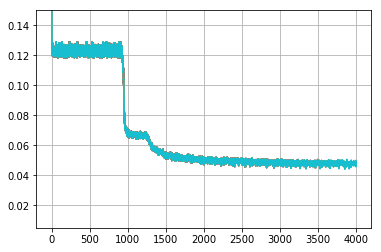

In [139]:
loss_acc = []

for ep in range(1000):

    random.shuffle(X)

    for batch in X:
        x = Variable(FloatTensor(batch)).cuda()
        
        optimizer.zero_grad()
        y, mu, logvar = vae_net(x)
        loss = loss_function( y, x, mu, logvar, x.size()[0] )
        loss.backward()
        optimizer.step()

        loss_acc.append(loss.data[0])

    plt.ylim(0.005, 0.15)
    plt.grid(True)
    plt.plot(loss_acc)
    display.clear_output(wait=True)
    display.display(plt.gcf())

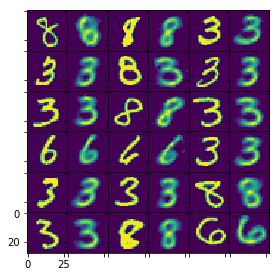

In [140]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid

fig = plt.figure(figsize=(20,20))

grid = AxesGrid(fig, 141,  # similar to subplot(141)
                nrows_ncols=(6, 6),
                axes_pad=0.00,
                label_mode="1",)
x = Variable(FloatTensor(X[0])).cuda()
y = vae_net(x)[0]
for i in range(0, 36, 2):
    im = grid[i].imshow(x[i].cpu().data.numpy().reshape((28,28)), interpolation="nearest")
    im = grid[i+1].imshow(y.cpu().data.numpy()[i,0], interpolation="nearest")

In [150]:
batch = Variable(FloatTensor(X[0])).cuda()
vae_net(batch)
z = vae_net.z.cpu().data.numpy().reshape(-1, 2)

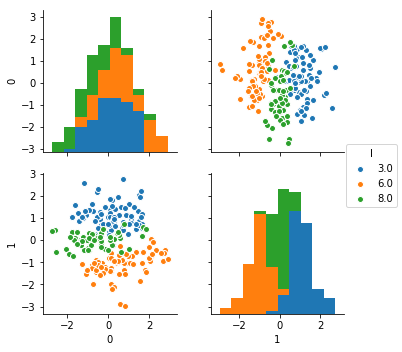

In [151]:
df = pd.DataFrame(z)
df['l'] = Y[0]

sbn.pairplot(df, hue='l', vars=[0, 1])

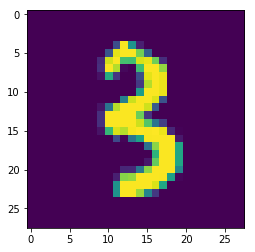

In [152]:
plt.imshow(b)
a_emb = vae_net(Variable(FloatTensor(b.reshape(1,1,28,28))).cuda())
a_emb = vae_net.z

In [154]:
print(a_emb.cpu().data.numpy().reshape(2))

[-0.06628736  0.91334307]


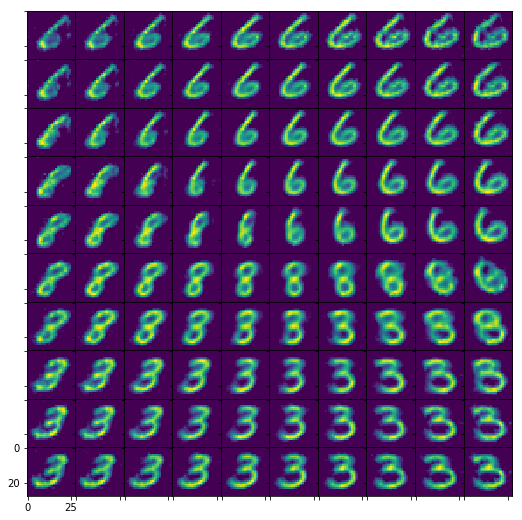

In [156]:
fig = plt.figure(figsize=(40,40))

grid = AxesGrid(fig, 141,  # similar to subplot(141)
                nrows_ncols=(10, 10),
                axes_pad=0.00,
                label_mode="1",)

for i in range(10):
    for j in range(10):
        a_emb[0,0,0,0] = (i-5)/2.;
        a_emb[0,1,0,0] = (j-5)/2.;
        y = vae_net.decoder(a_emb)
        im = grid[i+10*j].imshow(y.cpu().data.numpy()[0,0], interpolation="nearest")
